<a id='top'></a>

<a href='#import'>Import &amp; Inspect</a> | <a href='#columns'>Organize Columns</a> | <a href='#null'>Missing Data</a> | <a href='#duplicate'>Duplicate Data</a> | <a href='#time'>Time Data</a> | <a href='#variables'>Other Variables</a> | <a href='#summary'>Summary</a>
    
<br>

---



# Academic Mastery Study - Initial Data Exploration

**Improve academic evaluations by predicting whether a student will answer the next test question correctly.** Students taking advantage of practice exercises through various software applications seek an evaluation of their preparedness for formal academic assessments. They would like an an accurate evaluation of any gaps in knowledge and skills without sitting through exercises that repeatedly test established proficiencies and difficulties. The goal is to help test developers build an application that precisely evaluates competencies so that fewer demonstrations of proficiency can accurately determine mastery.

## THE DATASETS
---
Available from the [Grockit competition on Kaggle]( https://www.kaggle.com/c/WhatDoYouKnow/data):
```python
category_labels.csv
test.csv
training.csv
```
**Test** data does not include `answer_id` or `outcome` (from which correctness could be determined).

The test/training split is derived by finding users who answered at least 6 questions, taking **one** of their answers (uniformly random, from their 6th question to their last), and inserting it into the **test set**.
* Any later answers by this user are removed, 
* and any earlier answers are included in the **training set**.  
* All answers from users not in the test set are also used for the training set (as they may be useful in estimating question parameters or baseline ability distributions).

The **test data** distribution is thus different from **training data** in ways that may be significant.  
* First, it does not include 'timeout' or 'skipped' outcomes: all test results are from the student actually answering the question.  
* Second, it is biased towards users with more questions in the training set and biased towards their later answers.  
* Third, it is one entry per user, so the distribution of various aspects of the data (such as correct/incorrect) is over users, not over all answered questions.

<br>

### training.csv

**`correct`**: [**TARGET**] - `0` or `1`, indicating whether the student answered the question correctly.

**`outcome`**: [categorical] - a numeric code representing 'correct' (1), 'incorrect' (2), 'skipped' (3), or 'timeout' (4); a more detailed indicator of the outcome.  Not present in test data.

**`user_id`**: [**categorical**] - anonymized numeric identifier for the user answering the question.
       
**`question_id`**: [**categorical**] - a numeric identifier for the question being answered.
     
**`question_type`**: [**categorical**] - a numeric code representing the type of question; either 'MultipleChoiceOneCorrect' (0) for multiple choice, or 'SPR' (1) for free response questions.
   
**`group_name`**: [**categorical**] - a numeric code representing the test group for this question `{'act':0, 'gmat':1, 'sat':2}`.

`group_name`

     track_name   
        
        subtrack_name
        
**`track_name`**: [**categorical**] - the numeric code for the track within the test group for this question (mappings from category fields to numeric values are in `category_labels.csv`).

**`subtrack_name`**: [**categorical**] - the numeric code for the subtrack within the track for this question (mappings from category fields to numeric values are in `category_labels.csv`).

**`tag_string`**: [**categorical**] - a space-separated list of tag ids for this question (mappings from category fields to numeric values are in `category_labels.csv`). To be renamed to **`tag_ids`** after converting to comma separated list during data cleaning. These are not explored in this notebook, but will be evaluated later in the study.

**`round_started_at`**: [**numeric**] [reference datetime] - a UTC timestamp indicating when the question was available to the user.

**`answered_at`**: [**numeric**] - a UTC timestamp indicating when the user answered the question (NULL if not answered).

**`deactivated_at`**: [**numeric**] - a UTC timestamp indicating when the round finished, either because the user answered or the question timed-out.

**`answer_id`**: [categorical] - an id for the specific answer chosen in multiple choice questions.  Not present in test data.

**`game_type`**: [**categorical**] - indicates the type of game/study session (mappings from category fields to numeric values are in `category_labels.csv`). More information on each of these is provided in the relevant section of this document.

**`num_players`**: [**categorical**] - the number of players in the game at the time (multiple users can be viewing the same question simultaneously).

**`date_of_test`**: [numeric] - the date the user entered as their expected test date (if entered).

**`question_set_id`**: [categorical] - the question set for the question; most questions sets will only have one question; questions which share a question set id have a common presentation (such as a reading passage) and multiple questions based on that same information.

## DATA WRANGLING
---
Download the `grockit_all_data.zip` file from the [Grockit competition on Kaggle](https://www.kaggle.com/c/WhatDoYouKnow/data). Import and inspect raw training data. Isolate relevant variables, fill or calculate new variables, and organize the dataframe. Resolve missing, invalid, corrupted or duplicate values.

<a href='#top' id='import'>back to menu</a>

### Import Packages & Training Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from datetime import datetime

In [2]:
# Download grockit_all_data.zip from https://www.kaggle.com/c/WhatDoYouKnow/data,
# and save in the project's raw data directory.

# Read and save CSV file a as dataframe:
df = pd.read_csv('../data/raw/training.csv') 

### Inspect Raw Data

In [3]:
# Inspect the current state of the dataset:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4851475 entries, 0 to 4851474
Data columns (total 17 columns):
correct             int64
outcome             int64
user_id             int64
question_id         int64
question_type       int64
group_name          int64
track_name          int64
subtrack_name       int64
tag_string          object
round_started_at    object
answered_at         object
deactivated_at      object
answer_id           int64
game_type           int64
num_players         int64
date_of_test        object
question_set_id     int64
dtypes: int64(12), object(5)
memory usage: 629.2+ MB


The raw training dataset contains 17 variables (columns) and 4,851,475 observations (rows/entries/questions).

In [4]:
# Get a pre-wrangling count of users:
print( ("Number of Users Before 'Cleaning': "), len(df.user_id.value_counts()) ) 

Number of Users Before 'Cleaning':  179106


In [5]:
# Get a pre-wrangling count of unique questions:
print(("Number of Unique Questions Before 'Cleaning': "), (len( df.question_id.unique() )))

Number of Unique Questions Before 'Cleaning':  6045


In [6]:
# Inspect the structure and first 5 observations of the raw dataset:
df.head()

,correct,outcome,user_id,question_id,question_type,group_name,track_name,subtrack_name,tag_string,round_started_at,answered_at,deactivated_at,answer_id,game_type,num_players,date_of_test,question_set_id
0,0,2,85818,5560,0,1,5,14,222 233 240 246,2010-08-18 20:17:13,2010-08-18 20:18:18,2010-08-18 20:18:18,6540,7,1,NaN,1567
1,1,1,85818,4681,0,1,5,0,24 49,2010-08-18 20:19:12,2010-08-18 20:20:34,2010-08-18 20:20:34,4742,7,1,NaN,1227
2,1,1,85818,1529,0,1,5,0,31 49,2010-08-18 20:20:42,2010-08-18 20:21:56,2010-08-18 20:21:56,4309,7,1,NaN,1148
3,1,1,85818,2908,0,1,5,0,31 49,2010-08-18 20:22:03,2010-08-18 20:23:05,2010-08-18 20:23:05,4408,7,1,NaN,1168
4,1,1,85818,1773,0,1,5,11,183 194 207,2010-08-18 20:23:11,2010-08-18 20:26:08,2010-08-18 20:26:08,10822,7,1,NaN,2318


In [7]:
# Inspect the last 5 observations:
df.tail()

,correct,outcome,user_id,question_id,question_type,group_name,track_name,subtrack_name,tag_string,round_started_at,answered_at,deactivated_at,answer_id,game_type,num_players,date_of_test,question_set_id
4851470,1,1,58569,1633,0,1,4,9,47 82 118 161,2009-10-18 17:08:32,2009-10-18 17:09:06,2009-10-18 17:09:06,8811,7,1,2009-09-18,2017
4851471,0,4,58569,1775,0,1,4,1,4 52 135 262,2009-10-18 17:09:24,NaN,2009-10-18 17:10:03,25553,7,1,2009-09-18,2406
4851472,0,4,131842,1655,0,2,8,5,106 130 164,2010-04-19 23:13:02,NaN,2010-04-19 23:13:37,25553,7,5,NaN,368
4851473,0,4,131842,544,0,2,8,3,101 103 134 280,2010-04-19 23:13:48,NaN,2010-04-19 23:14:35,25553,7,5,NaN,470
4851474,0,4,52513,1272,0,2,7,13,239 245,2010-05-18 14:32:59,NaN,2010-05-18 14:35:15,25553,7,1,NaN,3676


Variables can be eliminated. Rows could be indexed and columns could be ordered more appropriately. Some of the date/time observations contain NULL values.

<a href='#top' id='columns'>back to menu</a>

### Organize Columns

Some columns, such as those not included in the test dataset, are removed. New columns, `round_ended_at` and `round_duration`, are created with the appropriate manipulation or calculation. Time data is scrutinized later so relevant variables need to be converted to datetime.

In [8]:
# Create and save list of columns to convert to datetime:
time_columns = ['round_started_at', 'answered_at', 'deactivated_at']

# Loop through the time_columns list:
for column in time_columns:
    # Convert date strings to datetime objects; 
    # need to ‘coerce’ errors, since there are known NULL values:
    df[column] = pd.to_datetime(df[column], errors='coerce')

In [9]:
# Drop selected columns and save results:
df = df.drop(['outcome', 'answer_id', 'question_set_id'], axis='columns')

In [10]:
# Fill round_ended_at with answered_at value unless NULL, if so fill with deactivated_at:
df['round_ended_at'] = df['answered_at'].fillna(df['deactivated_at'])

# Inspect the NULL answered_at observations to confirm:
df[df.answered_at.isnull()].head()

,correct,user_id,question_id,question_type,group_name,track_name,subtrack_name,tag_string,round_started_at,answered_at,deactivated_at,game_type,num_players,date_of_test,round_ended_at
10,0,85818,1338,0,1,5,11,193 207,2010-08-18 20:38:36,NaT,2010-08-18 20:39:24,7,1,NaN,2010-08-18 20:39:24
14,0,85818,2946,0,1,5,14,233 246,2010-08-20 14:27:06,NaT,2010-08-20 14:27:53,7,3,NaN,2010-08-20 14:27:53
17,0,85818,4884,0,1,5,14,221 226 227 233 246,2010-08-20 14:32:40,NaT,2010-08-20 14:34:40,7,3,NaN,2010-08-20 14:34:40
18,0,85818,5085,0,1,5,14,224 227 233 241 246,2010-08-20 14:35:02,NaT,2010-08-20 14:37:02,7,3,NaN,2010-08-20 14:37:02
21,0,85818,874,0,1,5,14,227 233 235 246,2010-08-20 14:39:54,NaT,2010-08-20 14:41:54,7,3,NaN,2010-08-20 14:41:54


Now one column, rather than one of two, indicates when each question round ended. If no value is available for `answered_at`, then the value for `deactivated_at` is used.

In [11]:
# Split the space delimited tag_string into a list of tag_ids
df['tag_string'] = df.tag_string.str.split(' ')

# Change the name of 'tag_string' column to tag_ids:
df = df.rename(columns = {'tag_string':'tag_ids'})

# Confirm the changes:
df.tag_ids.head()

0    [222, 233, 240, 246]
1                [24, 49]
2                [31, 49]
3                [31, 49]
4         [183, 194, 207]
Name: tag_ids, dtype: object

In [12]:
# Reorder the columns and save:
column_labels = ['user_id', 'round_started_at', 'answered_at', 'deactivated_at', 'round_ended_at', 'question_id', 'correct', 'group_name', 'track_name', 'subtrack_name', 'tag_ids', 'question_type', 'game_type', 'num_players', 'date_of_test']
df = df[column_labels]

# Reinspect the structure to confirm:
df.head()

,user_id,round_started_at,answered_at,deactivated_at,round_ended_at,question_id,correct,group_name,track_name,subtrack_name,tag_ids,question_type,game_type,num_players,date_of_test
0,85818,2010-08-18 20:17:13,2010-08-18 20:18:18,2010-08-18 20:18:18,2010-08-18 20:18:18,5560,0,1,5,14,"[222, 233, 240, 246]",0,7,1,NaN
1,85818,2010-08-18 20:19:12,2010-08-18 20:20:34,2010-08-18 20:20:34,2010-08-18 20:20:34,4681,1,1,5,0,"[24, 49]",0,7,1,NaN
2,85818,2010-08-18 20:20:42,2010-08-18 20:21:56,2010-08-18 20:21:56,2010-08-18 20:21:56,1529,1,1,5,0,"[31, 49]",0,7,1,NaN
3,85818,2010-08-18 20:22:03,2010-08-18 20:23:05,2010-08-18 20:23:05,2010-08-18 20:23:05,2908,1,1,5,0,"[31, 49]",0,7,1,NaN
4,85818,2010-08-18 20:23:11,2010-08-18 20:26:08,2010-08-18 20:26:08,2010-08-18 20:26:08,1773,1,1,5,11,"[183, 194, 207]",0,7,1,NaN


In [13]:
# Inspect the restructured state of the dataframe:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4851475 entries, 0 to 4851474
Data columns (total 15 columns):
user_id             int64
round_started_at    datetime64[ns]
answered_at         datetime64[ns]
deactivated_at      datetime64[ns]
round_ended_at      datetime64[ns]
question_id         int64
correct             int64
group_name          int64
track_name          int64
subtrack_name       int64
tag_ids             object
question_type       int64
game_type           int64
num_players         int64
date_of_test        object
dtypes: datetime64[ns](4), int64(9), object(2)
memory usage: 555.2+ MB


Since 3 columns were dropped, and 1 new column created, there are now 15 data columns.

<a href='#top' id='null'>back to menu</a>

### Evaluate & Resolve Missing Data

In [14]:
# Get a NULL count for each column in the dataframe:
df.isnull().sum() 

user_id                   0
round_started_at         69
answered_at          556088
deactivated_at          100
round_ended_at           90
question_id               0
correct                   0
group_name                0
track_name                0
subtrack_name             0
tag_ids                   0
question_type             0
game_type                 0
num_players               0
date_of_test        3824208
dtype: int64

According to information provided with the datasets for this project, `date_of_test` is the date the user entered as their expected test date (**if entered**). Nearly 80% of these values are NULL, but that does not indicate how many users are associated with no date entered.

The information also indicates that missing values from the `answered_at` column are NULL if not answered, so NULL in this case seems to be valuable information.

The NULL counts for `round_started_at` and `deactivated_at` are a bit of a mystery, so they are examined first.

In [15]:
# Create and apply the filter for NULL values in the round_started_at column, inspect:
df[df.round_started_at.isnull()]

,user_id,round_started_at,answered_at,deactivated_at,round_ended_at,question_id,correct,group_name,track_name,subtrack_name,tag_ids,question_type,game_type,num_players,date_of_test
502701,56022,NaT,NaT,NaT,NaT,5488,0,2,8,5,"[79, 106, 172, 280]",0,10,1,NaN
502702,56022,NaT,NaT,NaT,NaT,2315,0,2,8,5,"[41, 106, 143]",0,10,1,NaN
560170,76463,NaT,NaT,NaT,NaT,5488,1,2,8,5,"[79, 106, 172, 280]",0,10,1,NaN
560171,76463,NaT,NaT,NaT,NaT,2315,0,2,8,5,"[41, 106, 143]",0,10,1,NaN
560172,76463,NaT,NaT,NaT,NaT,225,1,2,6,7,"[5, 131, 138]",0,10,1,NaN
560173,76463,NaT,NaT,NaT,NaT,5277,1,2,6,7,"[1, 5, 108, 131, 269, 279]",0,10,1,NaN
565302,13469,NaT,NaT,NaT,NaT,5488,0,2,8,5,"[79, 106, 172, 280]",0,10,1,NaN
565303,13469,NaT,NaT,NaT,NaT,2315,0,2,8,5,"[41, 106, 143]",0,10,1,NaN
565304,13469,NaT,NaT,NaT,NaT,225,1,2,6,7,"[5, 131, 138]",0,10,1,NaN
902333,75026,NaT,NaT,NaT,NaT,5488,0,2,8,5,"[79, 106, 172, 280]",0,10,1,NaN


There are 69 observations with no date/time info entered. The most noticeable pattern is that they all involve game_type 10 (StudyHallGame), described in the dataset documentation as "the newest type of game: in these, users are answering their own series of questions as though they were in a solo practice game, but there is a single 'study hall' chat where people can ask for help on questions." There are only 2698 observations of this game type in the dataset.

Nonetheless, time data may be an important factor in improving the efficiency of testing applications, so dropping the relatively few records with missing data seems appropriate.

In [16]:
# Drop all rows with NULL values for round_started_at, save the rest:
df = df.dropna(subset=['round_started_at']) 

In [17]:
# Create and apply the filter for NULL values in the deactivated_at column, inspect:
df[df.deactivated_at.isnull()]

,user_id,round_started_at,answered_at,deactivated_at,round_ended_at,question_id,correct,group_name,track_name,subtrack_name,tag_ids,question_type,game_type,num_players,date_of_test
68233,135094,2009-01-29 01:50:53,NaT,NaT,NaT,253,0,1,5,14,"[222, 232, 240, 246]",0,7,2,NaN
75692,122692,2009-06-25 17:35:54,2009-06-25 17:37:24,NaT,2009-06-25 17:37:24,4802,0,2,6,15,"[15, 137, 204, 261, 279]",1,7,3,2009-11-24
125247,21595,2009-04-20 21:17:58,NaT,NaT,NaT,4494,0,1,4,1,"[14, 52, 77, 160, 279]",0,7,5,NaN
131340,33450,2009-02-20 17:55:30,NaT,NaT,NaT,4632,0,1,5,14,"[233, 240, 246]",0,7,1,NaN
394570,118125,2009-02-17 18:57:42,NaT,NaT,NaT,5276,0,1,4,9,"[14, 135, 161]",0,7,1,NaN
501287,65358,2009-06-24 15:00:43,2009-06-24 15:01:58,NaT,2009-06-24 15:01:58,4802,0,2,6,15,"[15, 137, 204, 261, 279]",1,7,5,NaN
573508,97518,2009-06-29 15:19:56,2009-06-29 15:21:57,NaT,2009-06-29 15:21:57,4802,0,2,6,15,"[15, 137, 204, 261, 279]",1,7,5,2010-01-23
635613,122912,2008-10-30 19:34:32,NaT,NaT,NaT,1191,0,1,5,14,"[233, 238, 241, 246]",0,7,1,NaN
636051,51708,2008-12-24 20:20:17,NaT,NaT,NaT,4371,0,1,5,11,"[193, 207]",0,7,1,NaN
636853,57882,2008-10-21 02:43:55,NaT,NaT,NaT,5311,0,1,4,9,"[14, 113, 161, 250, 279]",0,7,1,NaN


In [18]:
len(df[df.deactivated_at.isnull()])

31

Of the 31 NULL observations for `deactivated_at`, all were marked incorrect and all are for the game type 7.

Observations above with a date/time entered for answered_at provide the necessary information and should remain - the NULL values for deactivated_at in those rows can be filled or ignored. Since the observations with NULL values for both columns are not useful, they are dropped.

In [19]:
print(len(df[df.deactivated_at.isnull() & df.answered_at.isnull()]))

# Drop all rows with NULL values for both answered_at and deactivated_at, save the rest:
df = df.dropna(subset=['answered_at', 'deactivated_at'], how='all') 

# Filter and confirm the remaining NULL values for deactivated_at:
df[df.deactivated_at.isnull()]

21


,user_id,round_started_at,answered_at,deactivated_at,round_ended_at,question_id,correct,group_name,track_name,subtrack_name,tag_ids,question_type,game_type,num_players,date_of_test
75692,122692,2009-06-25 17:35:54,2009-06-25 17:37:24,NaT,2009-06-25 17:37:24,4802,0,2,6,15,"[15, 137, 204, 261, 279]",1,7,3,2009-11-24
501287,65358,2009-06-24 15:00:43,2009-06-24 15:01:58,NaT,2009-06-24 15:01:58,4802,0,2,6,15,"[15, 137, 204, 261, 279]",1,7,5,NaN
573508,97518,2009-06-29 15:19:56,2009-06-29 15:21:57,NaT,2009-06-29 15:21:57,4802,0,2,6,15,"[15, 137, 204, 261, 279]",1,7,5,2010-01-23
2182467,62107,2009-06-24 15:00:43,2009-06-24 15:03:18,NaT,2009-06-24 15:03:18,4802,0,2,6,15,"[15, 137, 204, 261, 279]",1,7,5,2009-12-05
2182473,62107,2009-06-24 15:14:55,2009-06-24 15:16:17,NaT,2009-06-24 15:16:17,4802,0,2,6,15,"[15, 137, 204, 261, 279]",1,7,5,2009-12-05
2255176,135617,2009-04-29 16:44:09,2009-04-29 16:45:49,NaT,2009-04-29 16:45:49,2096,0,2,6,15,"[5, 138, 261]",1,7,2,NaN
3013571,79815,2009-05-17 18:45:38,2009-05-17 18:46:40,NaT,2009-05-17 18:46:40,2734,0,1,5,14,"[220, 224, 227, 228, 246]",0,7,3,NaN
3271948,35763,2009-04-21 06:26:50,2009-04-21 06:27:44,NaT,2009-04-21 06:27:44,4723,0,1,4,9,"[14, 55, 77, 135, 161]",0,7,2,2009-07-17
3612310,107154,2009-04-15 22:33:50,2009-04-15 22:34:29,NaT,2009-04-15 22:34:29,2316,0,2,6,15,"[78, 137, 147, 261, 279]",1,7,5,2009-06-06
4452269,48073,2009-06-24 15:00:43,2009-06-24 15:02:11,NaT,2009-06-24 15:02:11,4802,0,2,6,15,"[15, 137, 204, 261, 279]",1,7,5,NaN


Those look fine to keep. Now, a closer look at the test date column. 

In [20]:
# Get the number of users remaining after dropping observations:
len(df.user_id.unique())

179093

In [21]:
# Get the number of users who entered a value for date_of_test:
len(df[df.date_of_test.notnull()].groupby('user_id').sum())

22534

In [22]:
# Get the number of users who did not enter a value for date_of_test:
len(df[df.date_of_test.isnull()].groupby('user_id').sum())

156559

Only 22,534 of the 179,103 users provided an expected test date. Given that nearly 90% of the users did not provide a date, this column will not be analyzed.

In [23]:
# Drop selected columns and save results:
df = df.drop('date_of_test', axis='columns')

In [24]:
# Get a new null count for each column in the dataframe:
df.isnull().sum() 

user_id                  0
round_started_at         0
answered_at         555998
deactivated_at          10
round_ended_at           0
question_id              0
correct                  0
group_name               0
track_name               0
subtrack_name            0
tag_ids                  0
question_type            0
game_type                0
num_players              0
dtype: int64

This is useful and expected. As confirmed earlier, the remaining observations where `deactivated_at` is NULL include valid `answered_at values`. Either value is necessary to determine the `round_ended_at` feature.

### Resolve a Known NULL Issue

According to the game_type information provided, "NULL: 6 - values represent a data collection failure." So, NULL counts are not showing up for the game_type column because they are represented by 6.

In [25]:
# Get all observations where game_type value is 6:
df[df.game_type == 6]

,user_id,round_started_at,answered_at,deactivated_at,round_ended_at,question_id,correct,group_name,track_name,subtrack_name,tag_ids,question_type,game_type,num_players
134118,51203,2011-10-13 11:02:18,2011-10-13 04:08:18,2011-10-13 04:08:18,2011-10-13 04:08:18,5261,0,0,2,10,"[127, 171, 206]",0,6,1
134119,51203,2011-10-13 11:02:18,2011-10-13 04:08:18,2011-10-13 04:08:18,2011-10-13 04:08:18,5261,0,0,2,10,"[127, 171, 206]",0,6,1
134120,51203,2011-10-13 11:10:48,2011-10-13 04:16:48,2011-10-13 04:16:48,2011-10-13 04:16:48,5738,0,0,2,10,"[18, 33, 104, 171]",0,6,1
134121,51203,2011-10-13 11:10:48,2011-10-13 04:16:48,2011-10-13 04:16:48,2011-10-13 04:16:48,5738,0,0,2,10,"[18, 33, 104, 171]",0,6,1
134122,51203,2011-10-13 11:19:18,2011-10-13 04:25:18,2011-10-13 04:25:18,2011-10-13 04:25:18,5349,0,0,2,10,"[18, 91, 124, 206]",0,6,1
134123,51203,2011-10-13 11:19:18,2011-10-13 04:25:18,2011-10-13 04:25:18,2011-10-13 04:25:18,5349,0,0,2,10,"[18, 91, 124, 206]",0,6,1
134124,51203,2011-10-13 08:27:48,2011-10-13 04:33:48,2011-10-13 04:33:48,2011-10-13 04:33:48,399,0,0,2,10,"[0, 122, 171, 206]",0,6,1
134125,51203,2011-10-13 08:27:48,2011-10-13 04:33:48,2011-10-13 04:33:48,2011-10-13 04:33:48,399,0,0,2,10,"[0, 122, 171, 206]",0,6,1
134126,51203,2011-10-13 11:36:18,2011-10-13 04:42:18,2011-10-13 04:42:18,2011-10-13 04:42:18,4276,0,0,2,10,"[32, 132, 206]",0,6,1
134127,51203,2011-10-13 11:36:18,2011-10-13 04:42:18,2011-10-13 04:42:18,2011-10-13 04:42:18,4276,0,0,2,10,"[32, 132, 206]",0,6,1


Most, if not all, of the observations involve rounds with end times earlier than start times. Indeed, data collection seems to have failed. These are dropped.

In [26]:
# Apply the filter to the dataframe, drop the corresponding rows, save the rest:
df = df.drop(df[df.game_type == 6].index)

<a href='#top' id='duplicate'>back to menu</a>

### Evaluate & Resolve Duplicate Data

Duplicates of nearly every categorical variable might be expected; however, the combination of `user_id`, `round_started_at`, and `round_ended_at` is checked for duplicates, since it seems impossible for one user to have the same time stamp more than once.

In [27]:
# Set options to inspect ALL of the observations:
# pd.options.display.max_rows = 650

# Inspect duplicates of observations by user_id, round_started_at and round_ended_at:
df[df.duplicated(['user_id', 'round_started_at', 'round_ended_at'], keep=False)]

,user_id,round_started_at,answered_at,deactivated_at,round_ended_at,question_id,correct,group_name,track_name,subtrack_name,tag_ids,question_type,game_type,num_players
84917,20440,2010-01-20 09:45:20,NaT,2010-01-20 09:45:21,2010-01-20 09:45:21,4526,0,2,6,7,"[5, 80, 131, 279]",0,7,1
84918,20440,2010-01-20 09:45:20,NaT,2010-01-20 09:45:21,2010-01-20 09:45:21,5141,0,2,6,7,"[5, 53, 131, 159, 279]",0,7,4
161167,30954,2011-08-29 21:48:55,NaT,2011-08-29 21:48:55,2011-08-29 21:48:55,1727,0,0,3,12,"[34, 50, 102, 114, 123, 212, 243]",0,7,1
161168,30954,2011-08-29 21:48:55,NaT,2011-08-29 21:48:55,2011-08-29 21:48:55,3018,0,0,3,12,"[34, 45, 50, 56, 102, 114, 212, 243]",0,7,1
161169,30954,2011-08-29 21:48:55,NaT,2011-08-29 21:48:55,2011-08-29 21:48:55,2030,0,0,3,12,"[6, 50, 51, 129, 152, 243]",0,7,1
161171,30954,2011-08-29 21:48:56,NaT,2011-08-29 21:48:56,2011-08-29 21:48:56,5523,0,0,3,12,"[50, 51, 56, 129, 152, 243]",0,7,1
161172,30954,2011-08-29 21:48:56,NaT,2011-08-29 21:48:56,2011-08-29 21:48:56,3287,0,0,3,12,"[51, 102, 129, 152, 243]",0,7,1
161173,30954,2011-08-29 21:48:56,NaT,2011-08-29 21:48:56,2011-08-29 21:48:56,186,0,0,3,12,"[34, 35, 51, 129, 146, 243]",0,7,1
161175,30954,2011-08-29 21:48:57,NaT,2011-08-29 21:48:57,2011-08-29 21:48:57,5645,0,0,3,12,"[34, 35, 51, 102, 129, 243]",0,7,1
161176,30954,2011-08-29 21:48:57,NaT,2011-08-29 21:48:57,2011-08-29 21:48:57,1439,0,0,3,12,"[6, 34, 35, 51, 129, 243]",0,7,1


A number of the observations above involve the same start and end time. This warrants a closer look.

In [28]:
# Get all observations where round_ended_at times are before round_started_at time:
df[df['round_started_at'] >= df['round_ended_at']]

,user_id,round_started_at,answered_at,deactivated_at,round_ended_at,question_id,correct,group_name,track_name,subtrack_name,tag_ids,question_type,game_type,num_players
3727,44733,2011-05-30 14:40:37,NaT,2011-05-30 14:40:37,2011-05-30 14:40:37,1190,0,1,5,11,"[189, 207]",0,5,1
7564,156508,2010-03-02 17:41:08,NaT,2010-03-02 17:41:08,2010-03-02 17:41:08,200,0,0,1,6,"[82, 125, 128, 167, 168, 169, 214, 279]",0,7,1
9885,43762,2010-01-11 02:55:23,NaT,2010-01-11 02:55:23,2010-01-11 02:55:23,604,0,0,1,6,"[21, 64, 125, 268]",0,7,2
10914,3769,2011-03-30 22:59:10,2011-03-30 22:59:10,2011-03-30 22:59:12,2011-03-30 22:59:10,4905,0,2,6,7,"[5, 83, 119, 131, 169]",0,7,1
11124,94864,2010-02-24 13:15:55,NaT,2010-02-24 13:15:55,2010-02-24 13:15:55,4556,0,2,6,7,"[19, 53, 131, 159, 279]",0,5,3
16563,18373,2010-06-22 18:11:35,NaT,2010-06-22 18:11:35,2010-06-22 18:11:35,2528,0,2,6,7,"[5, 88, 131, 167, 176]",0,4,1
16955,36060,2010-04-21 17:04:13,2010-04-21 17:04:13,2010-04-21 17:04:13,2010-04-21 17:04:13,4529,0,2,7,8,"[145, 179, 190]",0,4,1
17506,23294,2011-09-09 17:59:21,NaT,2011-09-09 17:59:21,2011-09-09 17:59:21,5957,0,1,5,11,"[201, 207]",0,5,1
19689,110444,2011-06-17 17:21:40,2011-06-17 17:21:40,2011-06-17 17:21:41,2011-06-17 17:21:40,294,0,0,2,10,"[0, 100, 171, 206]",0,7,1
21168,18666,2009-12-24 22:39:58,NaT,2009-12-24 22:39:58,2009-12-24 22:39:58,2571,0,2,6,7,"[5, 80, 131, 256, 269, 279]",0,7,1


It seems illogical that a user would have time to read a question within one second. These are dropped along with any observations for which the start times are later than end times. Time data is explored further below.

In [29]:
# Apply the filter to the dataframe, drop the corresponding rows, save the rest:
df = df.drop(df[df['round_started_at'] >= df['round_ended_at']].index)

In [30]:
# Drop duplicates of the remaining observations:
df = df.drop_duplicates(['user_id', 'round_started_at', 'round_ended_at'])

<a id='time' href='#top'>back to menu</a>

### More Time Data Exploration
Inspect and analayze time data for other outliers. First, compute round duration.

In [31]:
# Calculate the round duration:
df['round_duration'] = df['round_ended_at'] - df['round_started_at']

# And inspect:
df.head()

,user_id,round_started_at,answered_at,deactivated_at,round_ended_at,question_id,correct,group_name,track_name,subtrack_name,tag_ids,question_type,game_type,num_players,round_duration
0,85818,2010-08-18 20:17:13,2010-08-18 20:18:18,2010-08-18 20:18:18,2010-08-18 20:18:18,5560,0,1,5,14,"[222, 233, 240, 246]",0,7,1,00:01:05
1,85818,2010-08-18 20:19:12,2010-08-18 20:20:34,2010-08-18 20:20:34,2010-08-18 20:20:34,4681,1,1,5,0,"[24, 49]",0,7,1,00:01:22
2,85818,2010-08-18 20:20:42,2010-08-18 20:21:56,2010-08-18 20:21:56,2010-08-18 20:21:56,1529,1,1,5,0,"[31, 49]",0,7,1,00:01:14
3,85818,2010-08-18 20:22:03,2010-08-18 20:23:05,2010-08-18 20:23:05,2010-08-18 20:23:05,2908,1,1,5,0,"[31, 49]",0,7,1,00:01:02
4,85818,2010-08-18 20:23:11,2010-08-18 20:26:08,2010-08-18 20:26:08,2010-08-18 20:26:08,1773,1,1,5,11,"[183, 194, 207]",0,7,1,00:02:57


In [32]:
# Get round_duration statistics:
df.round_duration.describe()

count                   4846730
mean     0 days 00:01:07.679064
std      0 days 00:19:49.418308
min             0 days 00:00:01
25%             0 days 00:00:26
50%             0 days 00:00:51
75%             0 days 00:01:31
max            28 days 03:21:38
Name: round_duration, dtype: object

The statistic that seems particularly odd is the max value. That a user took 28 days to answer a question should be investigated. A closer look at the mimimum duration to possibly evaluate the validity of very quick answers could also be helpful.

In [33]:
# Get the number of round durations greater than 1 day:
(df.round_duration > '1days').sum()

5

In [34]:
# Get the number of round durations greater than 1 hour:
(df.round_duration > '1hours').sum()

436

In [35]:
# View observations for round durations greater than 10 minutes:
df[df.round_duration > '10minutes']

,user_id,round_started_at,answered_at,deactivated_at,round_ended_at,question_id,correct,group_name,track_name,subtrack_name,tag_ids,question_type,game_type,num_players,round_duration
2037,14855,2011-07-27 17:35:25,NaT,2011-07-27 17:57:05,2011-07-27 17:57:05,4849,0,1,4,9,"[4, 81, 161]",0,7,1,00:21:40
2052,14855,2011-07-27 18:03:52,NaT,2011-07-27 18:15:43,2011-07-27 18:15:43,4617,0,1,4,1,"[7, 52, 82, 115, 142]",0,7,1,00:11:51
6862,93901,2010-06-13 19:18:56,NaT,2010-06-13 20:12:55,2010-06-13 20:12:55,2249,0,1,4,1,"[4, 14, 52, 55, 77, 117, 262]",0,7,1,00:53:59
7846,165609,2011-08-25 06:21:16,NaT,2011-08-25 06:52:53,2011-08-25 06:52:53,3073,0,1,4,1,"[11, 47, 52, 82, 118, 175]",0,7,1,00:31:37
16883,44495,2011-08-10 16:00:04,2011-08-10 16:33:06,2011-08-10 16:33:08,2011-08-10 16:33:06,3836,0,0,0,2,"[63, 65, 70, 173]",0,7,1,00:33:02
17994,48982,2011-09-23 12:20:14,NaT,2011-09-23 12:47:08,2011-09-23 12:47:08,1871,0,1,5,0,"[29, 49]",0,11,1,00:26:54
18432,48982,2011-10-09 09:39:02,2011-10-09 10:04:59,2011-10-09 10:05:01,2011-10-09 10:04:59,1947,0,1,4,9,"[160, 161, 279]",0,4,1,00:25:57
20388,173226,2011-09-17 10:49:48,NaT,2011-09-17 11:13:13,2011-09-17 11:13:13,5118,0,1,4,9,"[47, 82, 108, 161]",0,11,1,00:23:25
35875,67001,2011-06-24 17:30:18,NaT,2011-06-24 19:22:53,2011-06-24 19:22:53,2594,0,1,4,9,"[14, 68, 71, 161]",0,7,1,01:52:35
56526,88014,2011-03-02 05:08:33,2011-03-02 05:19:25,2011-03-02 05:19:26,2011-03-02 05:19:25,2024,0,1,4,9,"[11, 36, 82, 118, 142, 161, 271]",0,4,1,00:10:52


Dropping fewer than 5 thousand of nearly 5 million observations for question rounds that took 10 minutes or longer doesn't seem unreasonable.

In [36]:
# Apply the filter to the dataframe, drop the corresponding rows, save the rest:
df = df.drop(df[df.round_duration > '10minutes'].index)

In [37]:
# View observations for round durations less than 5 seconds:
df[df.round_duration < '5seconds']

,user_id,round_started_at,answered_at,deactivated_at,round_ended_at,question_id,correct,group_name,track_name,subtrack_name,tag_ids,question_type,game_type,num_players,round_duration
328,28612,2010-02-20 01:32:39,2010-02-20 01:32:43,2010-02-20 01:32:43,2010-02-20 01:32:43,4090,0,2,6,7,"[5, 131, 256, 264]",0,7,1,00:00:04
329,28612,2010-02-20 01:33:00,2010-02-20 01:33:01,2010-02-20 01:33:01,2010-02-20 01:33:01,64,0,2,6,7,"[76, 121, 131, 137, 157, 170, 269]",0,7,1,00:00:01
330,28612,2010-02-20 01:33:03,2010-02-20 01:33:06,2010-02-20 01:33:06,2010-02-20 01:33:06,5180,0,2,6,15,"[5, 170, 261, 269, 279]",1,7,1,00:00:03
331,28612,2010-02-20 01:33:09,2010-02-20 01:33:11,2010-02-20 01:33:11,2010-02-20 01:33:11,5039,0,2,6,7,"[71, 131, 137]",0,7,1,00:00:02
332,28612,2010-02-20 01:33:12,2010-02-20 01:33:14,2010-02-20 01:33:14,2010-02-20 01:33:14,5333,1,2,6,7,"[5, 60, 80, 131]",0,7,1,00:00:02
360,71016,2010-11-17 01:39:07,2010-11-17 01:39:09,2010-11-17 01:39:11,2010-11-17 01:39:09,3284,0,2,6,7,"[5, 53, 80, 87, 131]",0,7,1,00:00:02
361,71016,2010-11-17 01:39:13,2010-11-17 01:39:15,2010-11-17 01:39:16,2010-11-17 01:39:15,948,0,2,6,7,"[83, 119, 131, 169]",0,7,1,00:00:02
362,71016,2010-11-17 01:39:17,2010-11-17 01:39:19,2010-11-17 01:39:20,2010-11-17 01:39:19,553,0,2,6,7,"[5, 78, 131, 137]",0,7,1,00:00:02
363,71016,2010-11-17 01:39:21,2010-11-17 01:39:23,2010-11-17 01:39:24,2010-11-17 01:39:23,2446,0,2,6,7,"[5, 78, 131, 137]",0,7,1,00:00:02
364,71016,2010-11-17 01:39:25,2010-11-17 01:39:27,2010-11-17 01:39:28,2010-11-17 01:39:27,4157,0,2,6,7,"[5, 131, 256, 269]",0,7,1,00:00:02


It seems humanly impossible to read, process and answer a question within even 10 seconds. A threshold of 5 seconds should safely reconcile such with questions that are easy to read and answer.

In [38]:
# Apply the filter to the dataframe, drop the corresponding rows, save the rest:
df = df.drop(df[df.round_duration < '5seconds'].index)

In [39]:
# Get new round_duration statistics:
df.round_duration.describe()

count                   4679166
mean     0 days 00:01:07.452851
std      0 days 00:00:53.989559
min             0 days 00:00:05
25%             0 days 00:00:28
50%             0 days 00:00:53
75%             0 days 00:01:33
max             0 days 00:10:00
Name: round_duration, dtype: object

There are now 4,679,166 observations in the dataframe and all have a round duration somewhere between 5 seconds and 10 minutes. 

<a id='variables' href='#top'>back to menu</a>

### Quick Inspection of Other Variables

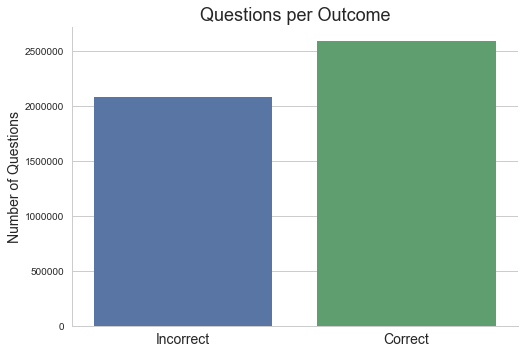

In [40]:
# Set the plot style:
sns.set_style('whitegrid')

# Create bar plot for outcome distribution:
sns.countplot(data=df, x='correct');

# Create bar labels:
plt.xticks(np.arange(2), ('Incorrect', 'Correct'), fontsize=14)

# Create axis labels and the title:
plt.xlabel('')
plt.ylabel('Number of Questions', fontsize=14)
plt.title('Questions per Outcome', fontsize=18)

# Minimize the plot frame:
sns.despine()

# Display the plot:
plt.show()

In [41]:
# Count the number of unique user_id values:
print( ('Number of Users:'), len(df.user_id.unique()) ) 

Number of Users: 178342


In [42]:
# Count and save the number of questions per user:
questions_per_user = df.user_id.value_counts()
print(questions_per_user.head(2))

# Convert to a dataframe, reset the index for future plotting and drop resulting extra column:
questions_per_user = questions_per_user.to_frame('question_count').reset_index().drop('index', axis='columns')

# Print the first 5 observations and inspect:
questions_per_user.head()

133472    8465
169858    7039
Name: user_id, dtype: int64


,question_count
0,8465
1,7039
2,6827
3,6543
4,6539


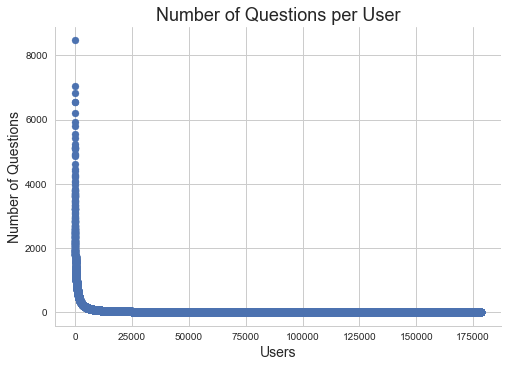

In [43]:
# Create questions_per_user scatter plot:
plt.scatter(questions_per_user.index, questions_per_user.question_count)

# Create the labels and title of the plot:
plt.xlabel('Users', fontsize=14)
plt.ylabel('Number of Questions', fontsize=14)
plt.title('Number of Questions per User', fontsize=18)

# Minimize the plot frame:
sns.despine()

# Save and display the plot:
plt.savefig('../reports/figures/initial_data_exploration/questions_per_user.png')
plt.show()  

It looks like a small percent of users attempted a large number of questions and a large percent attempted a small number of questions. This may be important to keep in mind moving forward.

In [44]:
# Print the number of unique question_id values:
print(('Number of Unique Questions:'), (len( df.question_id.unique() )))

Number of Unique Questions: 6045


In [45]:
# Count and save the number of questions per question_id:
questions_per_questionid = df.question_id.value_counts()
questions_per_questionid.head(10)

4059    14281
1272    13377
1928    10274
4952    10257
4444    10071
1883    10034
2179     9872
5252     9206
5706     8970
1856     8918
Name: question_id, dtype: int64

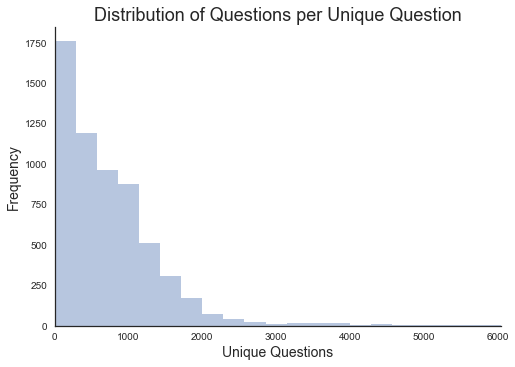

In [46]:
# Set the plot style:
sns.set_style('white')

# Create a histogram of questions_per_questionid:
sns.distplot(questions_per_questionid, kde=False)

# Set each axis scale and limits:
plt.xlim(0,6050)

# Create a title:
plt.xlabel('Unique Questions', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Questions per Unique Question', fontsize=18)

# Minimize the plot frame:
sns.despine()

# Display the plot:
plt.savefig('../reports/figures/initial_data_exploration/questions_per_questionid.png')
plt.show() 

The long tail here was more unexpected. Perhaps the questions with low frequency are grouped somehow? Nonetheless, this is another feature to keep in mind. 

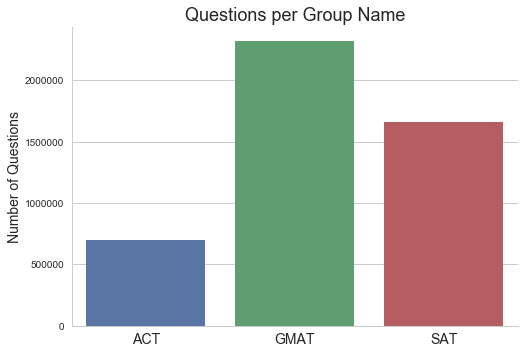

In [47]:
# Set the plot style:
sns.set_style('whitegrid')

# Create bar plot for group_name distribution:
sns.countplot(data=df, x="group_name")

# Create bar labels:
# {'act':0, 'gmat':1, 'sat':2}
plt.xticks(np.arange(3), ('ACT', 'GMAT', 'SAT'), fontsize=14)

# Create axis labels and the title:
plt.xlabel('')
plt.ylabel('Number of Questions', fontsize=14)
plt.title('Questions per Group Name', fontsize=18)

# Minimize the plot frame:
sns.despine()

# Display the plot:
plt.show()

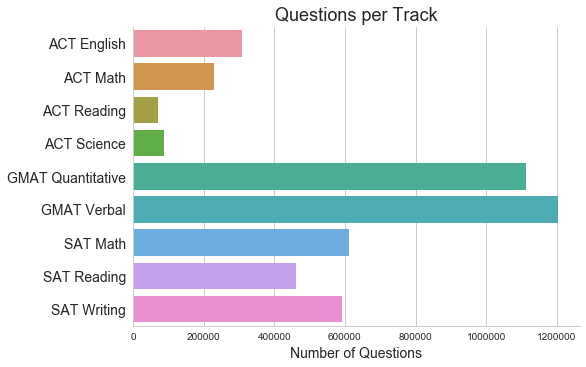

In [48]:
# Create bar plot for track_name distribution:
sns.countplot(data=df, y='track_name')

# Create bar labels:
tracks = ('ACT English', 'ACT Math', 'ACT Reading', 'ACT Science', 'GMAT Quantitative', 
              'GMAT Verbal', 'SAT Math', 'SAT Reading', 'SAT Writing')
plt.yticks(np.arange(len(tracks)), tracks, fontsize=14)

# Create axis labels and the title:
plt.xlabel('Number of Questions', fontsize=14)
plt.ylabel('')
plt.title('Questions per Track', fontsize=18)

# Minimize the plot frame:
sns.despine()

# Display the plot:
plt.show()

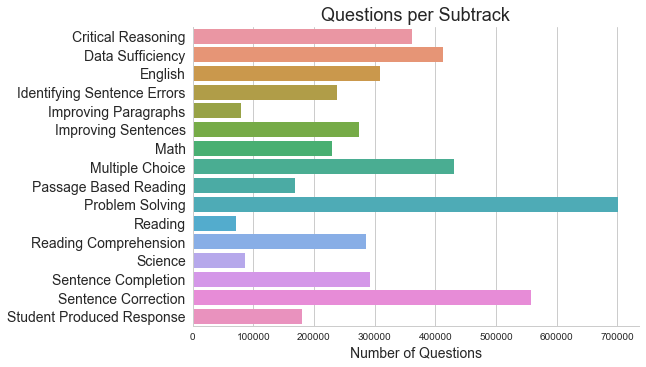

In [49]:
# Create bar plot for subtrack_name distribution:
sns.countplot(data=df, y='subtrack_name')

# Create bar labels:
subtracks = ('Critical Reasoning', 'Data Sufficiency', 'English', 'Identifying Sentence Errors', 
             'Improving Paragraphs', 'Improving Sentences', 'Math', 'Multiple Choice', 
             'Passage Based Reading', 'Problem Solving', 'Reading', 'Reading Comprehension', 
             'Science', 'Sentence Completion', 'Sentence Correction', 'Student Produced Response')
plt.yticks(np.arange(len(subtracks)), subtracks, fontsize=14)

# Create axis labels and the title:
plt.xlabel('Number of Questions', fontsize=14)
plt.ylabel('')
plt.title('Questions per Subtrack', fontsize=18)

# Minimize the plot frame:
sns.despine()

# Display the plot:
plt.show()

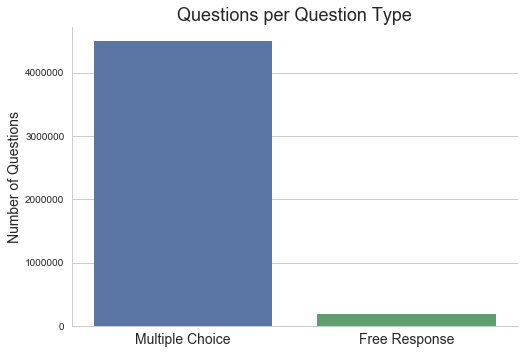

In [50]:
# Create bar plot for outcome distribution:
sns.countplot(data=df, x='question_type')

# Create bar labels:
plt.xticks(np.arange(2), ('Multiple Choice', 'Free Response'), fontsize=14)

# Create axis labels and the title:
plt.xlabel('')
plt.ylabel('Number of Questions', fontsize=14)
plt.title('Questions per Question Type', fontsize=18)

# Minimize the plot frame:
sns.despine()

# Display the plot:
plt.show()

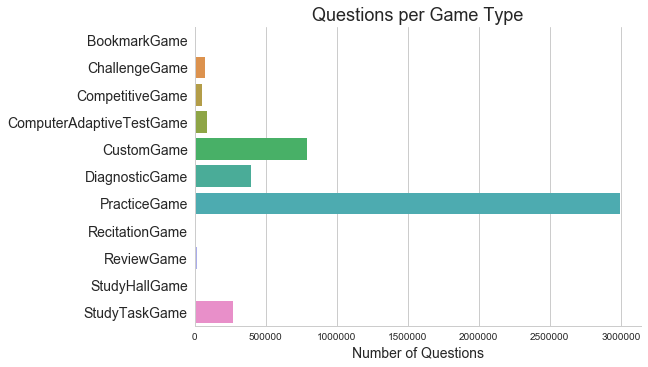

In [51]:
# Create bar plot for game_type distribution:
sns.countplot(data=df, y='game_type')

# Create bar labels:
game_types = ('BookmarkGame', 'ChallengeGame', 'CompetitiveGame', 'ComputerAdaptiveTestGame', 
              'CustomGame', 'DiagnosticGame', 'PracticeGame', 'RecitationGame', 
              'ReviewGame', 'StudyHallGame', 'StudyTaskGame')
plt.yticks(np.arange(len(game_types)), game_types, fontsize=14)

# Create axis labels and the title:
plt.xlabel('Number of Questions', fontsize=14)
plt.ylabel('')
plt.title('Questions per Game Type', fontsize=18)

# Minimize the plot frame:
sns.despine()

# Display the plot:
plt.show()

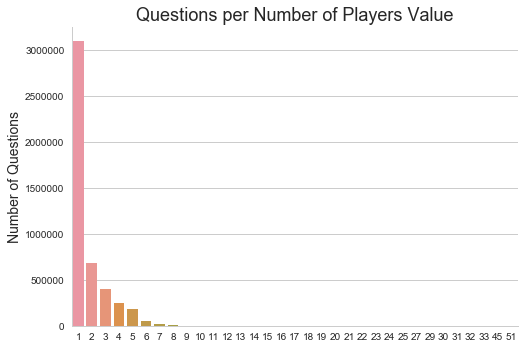

In [52]:
# Create bar plot for outcome distribution:
sns.countplot(data=df, x='num_players')

# Create axis labels and the title:
plt.xlabel('')
plt.ylabel('Number of Questions', fontsize=14)
plt.title('Questions per Number of Players Value', fontsize=18)

# Minimize the plot frame:
sns.despine()

# Display the plot:
plt.show()

### Wrap Up & Inspect Before Saving

For the next phase of data exploration, one more dataframe manipulation will be helpful before saving the clean dataset. Tags need to be extracted from the tag_ids lists:

In [54]:
# Create new dataframe of 'tag_ids':
tags = df['tag_ids'].apply(pd.Series)

# Inspect the tags dataframe:
tags.head()

,0,1,2,3,4,5,6,7,8
0,222,233,240,246,NaN,NaN,NaN,NaN,NaN
1,24,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,31,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,31,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,183,194,207,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
# Rename each tag_id column:
tags = tags.rename(columns = lambda x : 'tag_' + str(x))

In [56]:
# Fill NULL values with 0 and convert all to integers:
tags = tags.fillna(0).astype('int')

# Confirm changes:
print(tags.info())
tags.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4679166 entries, 0 to 4679165
Data columns (total 9 columns):
tag_0    int64
tag_1    int64
tag_2    int64
tag_3    int64
tag_4    int64
tag_5    int64
tag_6    int64
tag_7    int64
tag_8    int64
dtypes: int64(9)
memory usage: 321.3 MB
None


,tag_0,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8
0,222,233,240,246,0,0,0,0,0
1,24,49,0,0,0,0,0,0,0
2,31,49,0,0,0,0,0,0,0
3,31,49,0,0,0,0,0,0,0
4,183,194,207,0,0,0,0,0,0


In [57]:
# Concatenate the tags dataframe with the original dataframe:
df = pd.concat([df[:], tags[:]], axis=1)

In [58]:
# Set options to inspect ALL of the columns:
pd.options.display.max_columns = 25

# Re-inspect the state and structure of the dataframe:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4679166 entries, 0 to 4679165
Data columns (total 24 columns):
user_id             int64
round_started_at    datetime64[ns]
answered_at         datetime64[ns]
deactivated_at      datetime64[ns]
round_ended_at      datetime64[ns]
question_id         int64
correct             int64
group_name          int64
track_name          int64
subtrack_name       int64
tag_ids             object
question_type       int64
game_type           int64
num_players         int64
round_duration      timedelta64[ns]
tag_0               int64
tag_1               int64
tag_2               int64
tag_3               int64
tag_4               int64
tag_5               int64
tag_6               int64
tag_7               int64
tag_8               int64
dtypes: datetime64[ns](4), int64(18), object(1), timedelta64[ns](1)
memory usage: 856.8+ MB
None


,user_id,round_started_at,answered_at,deactivated_at,round_ended_at,question_id,correct,group_name,track_name,subtrack_name,tag_ids,question_type,game_type,num_players,round_duration,tag_0,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8
0,85818,2010-08-18 20:17:13,2010-08-18 20:18:18,2010-08-18 20:18:18,2010-08-18 20:18:18,5560,0,1,5,14,"[222, 233, 240, 246]",0,7,1,00:01:05,222,233,240,246,0,0,0,0,0
1,85818,2010-08-18 20:19:12,2010-08-18 20:20:34,2010-08-18 20:20:34,2010-08-18 20:20:34,4681,1,1,5,0,"[24, 49]",0,7,1,00:01:22,24,49,0,0,0,0,0,0,0
2,85818,2010-08-18 20:20:42,2010-08-18 20:21:56,2010-08-18 20:21:56,2010-08-18 20:21:56,1529,1,1,5,0,"[31, 49]",0,7,1,00:01:14,31,49,0,0,0,0,0,0,0
3,85818,2010-08-18 20:22:03,2010-08-18 20:23:05,2010-08-18 20:23:05,2010-08-18 20:23:05,2908,1,1,5,0,"[31, 49]",0,7,1,00:01:02,31,49,0,0,0,0,0,0,0
4,85818,2010-08-18 20:23:11,2010-08-18 20:26:08,2010-08-18 20:26:08,2010-08-18 20:26:08,1773,1,1,5,11,"[183, 194, 207]",0,7,1,00:02:57,183,194,207,0,0,0,0,0,0


In [59]:
# Inspect the last records too:
df.tail()

,user_id,round_started_at,answered_at,deactivated_at,round_ended_at,question_id,correct,group_name,track_name,subtrack_name,tag_ids,question_type,game_type,num_players,round_duration,tag_0,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8
4679161,58569,2009-10-18 17:08:32,2009-10-18 17:09:06,2009-10-18 17:09:06,2009-10-18 17:09:06,1633,1,1,4,9,"[47, 82, 118, 161]",0,7,1,00:00:34,47,82,118,161,0,0,0,0,0
4679162,58569,2009-10-18 17:09:24,NaT,2009-10-18 17:10:03,2009-10-18 17:10:03,1775,0,1,4,1,"[4, 52, 135, 262]",0,7,1,00:00:39,4,52,135,262,0,0,0,0,0
4679163,131842,2010-04-19 23:13:02,NaT,2010-04-19 23:13:37,2010-04-19 23:13:37,1655,0,2,8,5,"[106, 130, 164]",0,7,5,00:00:35,106,130,164,0,0,0,0,0,0
4679164,131842,2010-04-19 23:13:48,NaT,2010-04-19 23:14:35,2010-04-19 23:14:35,544,0,2,8,3,"[101, 103, 134, 280]",0,7,5,00:00:47,101,103,134,280,0,0,0,0,0
4679165,52513,2010-05-18 14:32:59,NaT,2010-05-18 14:35:15,2010-05-18 14:35:15,1272,0,2,7,13,"[239, 245]",0,7,1,00:02:16,239,245,0,0,0,0,0,0,0


<a id='summary' href='#top'>back to menu</a>

## SAVE & SUMMARIZE
---

In [60]:
# Save the clean dataframe to the interim data directory:
# df.to_csv('../data/interim/clean_training.csv')

### Training Dataset

|                    |TOTAL OBSERVATIONS|TOTAL VARIABLES|NUMBER OF USERS|UNIQUE QUESTIONS|
|--------------------|------------------|---------------|---------------|----------------|
|**Before Cleaning** |4,851,475         |17             |179,106        |6,045           |
|**After Cleaning**  |4,679,166         |24             |178,342        |6,045           |
|**DROPPED**         |172,309           |(11 added) 4   |764            |0               |


### Data Wrangling Process
1. Import Packages, Dataset & Inspect
2. Organize Columns
3. Evaluate & Resolve Missing Data
4. Evaluate & Resolve Missing Data
5. Compute and Explore Time Data
6. Split Tags into Separate Feature Columns


### Initial Exploration

The most interesting of the initial views of variables were those of questions per user and per unique questions:

![Number of Questions Per User](../reports/figures/initial_data_exploration/questions_per_user.png)

It looks like a small percent of users attempted a large number of questions and a large percent attempted a small number of questions. This may be important to keep in mind moving forward.

![Number of Questions Per question_id](../reports/figures/initial_data_exploration/questions_per_questionid.png)

The long tail here was more unexpected. Perhaps the questions with low frequency are grouped somehow that explains why they are underrepresented? The distribution of groups and tracks may point to such. Nonetheless, this is another feature to keep in mind.

## DATA WRANGLING REPORT
---
A report of important steps taken to clean the `training.csv` dataset is available here: [../reports/data_wrangling.pdf](../reports/data_wrangling.pdf). This includes a detailed summary of work completed in this notebook.


## NEXT STEPS
---
# [Exploratory Data Analysis](http://nbviewer.jupyter.org/github/humburgc/academic_mastery_study/blob/master/notebooks/exploratory_data_analysis.ipynb?flush_cache=true)
